# Load libraries

In [82]:
import os
from tqdm import tqdm
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Exploring data

In [129]:
# read nrm files
nmr_folder = 'data/nmr_rand'
df_nmr = {'fn': [], 'i': [], 'j': [], 'dij': []}
for fn in tqdm(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        for edge in fd:
            i, j, dij = edge.split()[:3]
            # parse the edge
            i, j, dij = int(i), int(j), float(dij)
            # add the edge
            df_nmr['fn'].append(fn)
            df_nmr['i'].append(i)
            df_nmr['j'].append(j)
            df_nmr['dij'].append(dij)
# convert to dataframe
df_nmr = pd.DataFrame(df_nmr)
# add columns for dmax, pdb and chain
df_nmr['DMAX'] = df_nmr['fn'].apply(lambda fn: int(fn.split('dmax_')[1].split('.')[0]))
df_nmr['PDB'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[0])
df_nmr['chain'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[2])

100%|██████████| 147/147 [00:00<00:00, 26612.69it/s]


In [130]:
def get_lenS(fnmr):
    flog = fnmr.replace('.nmr', '.log')
    with open(flog, 'r') as fd:
        for row in fd:
            if '> lenS' in row:
                return int(row.split()[-1])
# columns of interest
cols = ['PDB','DMAX','i','j','fn']
dfA = df_nmr[cols].groupby(['PDB','DMAX']).agg({'i':'count', 'j':'max', 'fn':'max'}).reset_index()
dfA.rename(columns={'i':'|E|', 'j':'|V|'}, inplace=True)
# dict of dataframes, one for each dmax
df_DMAX = {dmax:None for dmax in dfA['DMAX'].unique()} 
for dmax in df_DMAX:
    df_DMAX[dmax] = dfA[dfA['DMAX'] == dmax].groupby(['PDB','|V|']).max().reset_index()
    # rename columns
    df_DMAX[dmax].rename(columns={'|E|':f'|E_{dmax}|','fn':f'|S_{dmax}|'}, inplace=True)
    # parse the log file to get the length of S
    df_DMAX[dmax][f'|S_{dmax}|'] = df_DMAX[dmax][f'|S_{dmax}|'].apply(get_lenS)
    # drop redundant columns
    if dmax == min(df_DMAX):
        df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    else:
        df_DMAX[dmax].drop(columns=['DMAX','|V|'], inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
# sort by |V|
df_DMAX = dfB.sort_values(by=['|V|'])
cols = df_DMAX.columns.tolist()
# change df_MAX column order
cols = cols[:2] + sorted(cols[2:])
df_DMAX = df_DMAX[cols]
# convert to latex
tex = df_DMAX.to_latex(index=False,
                column_format='lrrc',
                header=cols, # list of column names
                escape=False,
                caption=f'Number of nodes and edges for each instance.',
                label=f'tab:instances',
                multicolumn=False,
                multicolumn_format='c')
# save tex to file
with open('latex/tables/instances.tex', 'w') as fd:
    fd.write(tex)
# display
df_DMAX

,PDB,|V|,|E_5|,|S_5|
16,test5,17,5,7
14,test490,18,5,7
22,test591,18,5,8
4,test190,18,5,5
13,test475,18,5,6
47,test952,19,5,6
34,test763,19,5,8
35,test765,19,5,8
40,test874,19,5,6
30,test754,19,5,5


In [131]:
# |s| is the number of edges covering the segment s
df = {'PDB':[], 'DMAX':[], 'sid':[], '|s|':[]}
for fn in tqdm(os.listdir(nmr_folder)):
    # skip non-dmp files
    if not fn.endswith('.dmp'):
        continue
    # get pdb and dmax
    pdb = fn.split('_')[0]
    dmax = int(fn.split('dmax_')[1].split('.')[0])
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        reading = False # flag to start reading
        for row in fd:
            if 'segments [sid i j weight EID]:' in row:
                reading = True
                continue
            if 'E [idx eid i j SID]:' in row:
                break
            if reading:
                v = [int(s) for s in row.split()]
                sid, i, j = int(v[0]), int(v[1]), int(v[2])                
                df['PDB'].append(pdb)
                df['DMAX'].append(dmax)
                df['|s|'].append(len(v)-4)
                df['sid'].append(sid)
df = pd.DataFrame(df)
dfA = df.groupby(['DMAX']).agg({'|s|':'max'}).reset_index().sort_values(by=['DMAX'])
dfA.rename(columns={'|s|':'|s|_max'}, inplace=True)
print(dfA)


100%|██████████| 147/147 [00:00<00:00, 32226.78it/s]

   DMAX  |s|_max
0     5        5


In [132]:
fig = go.Figure()
for dmax in df['DMAX'].unique():
    dfB = df[df['DMAX'] == dmax].sort_values(by=['|s|'])
    y, PDB, SID = dfB['|s|'], dfB['PDB'], dfB['sid']
    x = np.arange(1, len(y)+1) / len(y)    
    fig.add_trace(go.Scatter(x=x, y=y, name=f'dmax={dmax}'))
    # add pdb to the hover text
    fig.data[-1].text = [f'{pdb}, sid:{sid}' for pdb, sid in zip(PDB, SID)]
# Overlay both histograms
fig.update_layout(barmode='overlay')
# xlim
fig.update_xaxes(range=[0, 1.05])
# set title
fig.update_layout(title_text='CDF of number of edges per segment')
# set x-axis title
fig.update_xaxes(title_text='CDF')
# set y-axis title
fig.update_yaxes(title_text='Number of edges on a given segment', type="log")
fig.show()

# Exploring results

In [168]:
nmr_folder = 'data/nmr_spec/'

# run read_results.py
os.system('python read_results.py -wdir ' + nmr_folder)

df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))

# extract DMAX and PDB ID from fnmr
df['PDB'] = df['fnmr'].apply(lambda x: x.split('/')[-1].split('_')[0].replace('.nmr', ''))
df['DMAX'] = df['fnmr'].apply(lambda x: int(x.split('_')[-1].replace('.nmr','')))

# change column names
df.rename(columns={'nnodes': '|V|', 'lenE': '|E|', 'lenS': '|S|'}, inplace=True)

# sort by DMAX and nnodes
df = df.sort_values(by=['DMAX', '|V|'])

df.head()

Parameters:
   wdir = data/nmr_spec/

Getting log files from wdir=data/nmr_spec/
Saving results to data/nmr_spec/results.csv


100%|██████████| 3/3 [00:00<00:00, 13706.88it/s]


,clean_log,costBB,costBF,costGD,costPT,costRX,costSB,dump,fnmr,|E|,...,timeBF,timeGD,timePT,timeSB,timeoutBB,timeoutPT,tmax,verbose,PDB,DMAX
0,True,92.0,92.0,136.0,92.0,92.0,198.0,1.0,data/nmr_spec/test892_chain_A_dmax_5.nmr,5,...,0.0,0.0,0.0,0.0,0.0,0.0,3600.0,True,test892,5
1,True,158.0,158.0,158.0,158.0,52.0,1040.0,1.0,data/nmr_spec/test189_chain_A_dmax_5.nmr,5,...,0.0,0.0,0.0,0.0,0.0,0.0,3600.0,True,test189,5
2,True,96.0,96.0,116.0,96.0,58.0,138.0,1.0,data/nmr_spec/test912_chain_A_dmax_5.nmr,5,...,0.0,0.0,0.0,0.0,0.0,0.0,3600.0,True,test912,5


In [173]:
# adjust columns
cols = list(df.columns)
print(cols)
# remove unwanted columns
cols_drop = ['clean_log','dump','fnmr','verbose']
for col in cols_drop:
    cols.remove(col)
print(cols)
# set column order
cols = [
    'PDB', 'DMAX', 'tmax', 
    '|E|', '|S|', '|V|', 
    'costRX', 'costBB', 'costBF', 'costGD', 'costPT', 'costSB',
    'timeBB', 'timeBF', 'timeGD', 'timePT', 'timeSB', 
    'timeoutBB', 'timeoutPT', 
]
df = df[cols]
df.head()


['PDB', 'DMAX', 'tmax', '|E|', '|S|', '|V|', 'costRX', 'costBB', 'costBF', 'costGD', 'costPT', 'costSB', 'timeBB', 'timeBF', 'timeGD', 'timePT', 'timeSB', 'timeoutBB', 'timeoutPT']


ValueError: list.remove(x): x not in list

In [180]:
# dispplay the number of instances with timeout
df.groupby('PDB').sum()[['timeoutBB', 'timeoutPT']].sort_values(by=['timeoutBB', 'timeoutPT'], ascending=False)

,timeoutBB,timeoutPT
PDB,,
test189,0.0,0.0
test892,0.0,0.0
test912,0.0,0.0


In [182]:
dfA = {'PDB':[], 'cost':[], 'method':[]}
for pdb in df['PDB'].unique():
    dfB = df[df['PDB'] == pdb]
    for col in dfB.columns:
        if col.startswith('cost'):
            dfA['PDB'].append(pdb)
            dfA['cost'].append(dfB[col].iloc[0])
            dfA['method'].append(col.replace('cost',''))
# convert to dataframe
dfA = pd.DataFrame(dfA)
# drop rows with method == 'RX'
dfA = dfA[dfA['method'] != 'RX']
# normalize cost for each pdb
dfA['min_cost'] = dfA.apply(lambda x: dfA[dfA['PDB'] == x['PDB']]['cost'].min(), axis=1)
dfA['relative cost'] = dfA['cost'] / dfA['min_cost']

fig = px.bar(dfA, x='PDB', y='relative cost', color='method', barmode='group', title='Relative cost of each method (lower is better)', text='relative cost')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

In [128]:
# number of timeouts
print('num timeoutBB:', df['timeoutBB'].sum().astype(int))
print('num timeoutPT:', df['timeoutPT'].sum().astype(int))
print()

# count number of pdb_id per DMAX
print('Number of PDB per DMAX:')
dfA = df[['DMAX','PDB']].groupby('DMAX').count().reset_index()
dfA

num timeoutBB: 0
num timeoutPT: 0

Number of PDB per DMAX:


,DMAX,PDB
0,5,8


In [ ]:
# pdb files description
cols = ['PDB', '|V|', '|E|', '|S|'] # columns to show
DMAX = df['DMAX'].unique()
for dmax in DMAX:
    dfA = df[df['DMAX']==dmax][cols].reset_index(drop=True)
    print(f'  - dfA.shape: {dfA.shape}')
    tex = dfA.to_latex(index=False,
                column_format='lrrc',
                header=cols, # list of column names
                escape=False,
                caption=f'Number of nodes, edges and segments for each PDB file (dmax={dmax}).',
                label=f'tab:pdb_dmax_{dmax}',
                multicolumn=False,
                multicolumn_format='c')
    # save tex to file
    with open(f'./latex/tables/pdb_dmax_{dmax}.tex', 'w') as f:
        f.write(tex)

In [ ]:
df50 = df[df['DMAX']=='50']
df60 = df[df['DMAX']=='60']

print('df50.shape:', df50.shape)
print('df50.shape:', df60.shape)

cols = ['|V|', '|E|', '|S|']
print(df50[cols].describe())
print(df60[cols].describe())

In [ ]:
# plot number of edges and segments
df50 = df[df['DMAX']=='50'][['PDB', '|V|', '|E|', '|S|']].reset_index(drop=True)
df50.rename(columns={'|E|': '|E|_50', '|S|': '|S|_50'}, inplace=True)
df60 = df[df['DMAX']=='60'][['PDB', '|E|', '|S|']].reset_index(drop=True)
df60.rename(columns={'|E|': '|E|_60', '|S|': '|S|_60'}, inplace=True)
dfA = df50.merge(df60, on='PDB')
fig = px.scatter(dfA, x='|V|', y=['|E|_50', '|E|_60','|S|_50','|S|_60'], hover_name='PDB', log_x=True, log_y=True)
fig.show()
# export figure
fig.write_image('./latex/figures/edges_segments.png')

In [ ]:
# plot number of edges and segments
fig = px.scatter(df, x='|V|', y='|E|', color='DMAX', hover_name='PDB', log_x=True, log_y=True)
# export figure
fig.write_image('./latex/figures/vertices_edges.png')

### Plot NMR Graph

In [30]:
def plot_graph(G, fnmr, savefig=False):
    print(fnmr)
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o', 
        node_color=node_color)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)
    if savefig:
        plt.savefig(fnmr.replace('.nmr', '.pdf'), format='pdf')
    plt.show()

data/nmr_test/testA.nmr


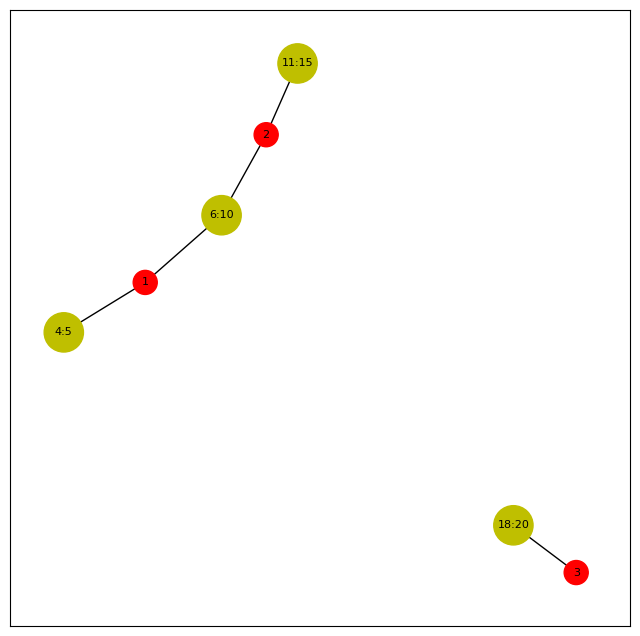

data/nmr_test/testB.nmr


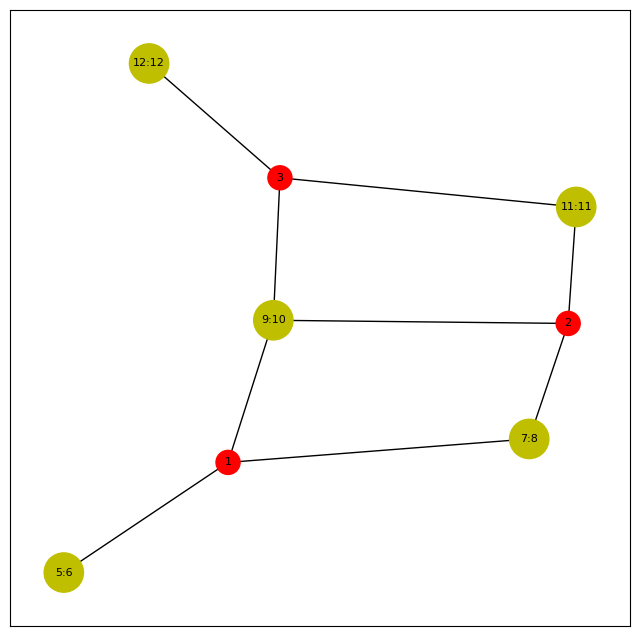

data/nmr_test/testC.nmr


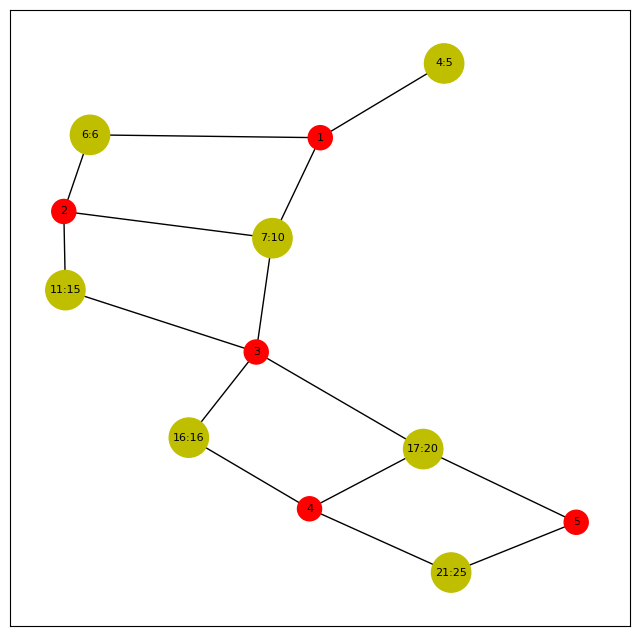

data/nmr_test/testD.nmr


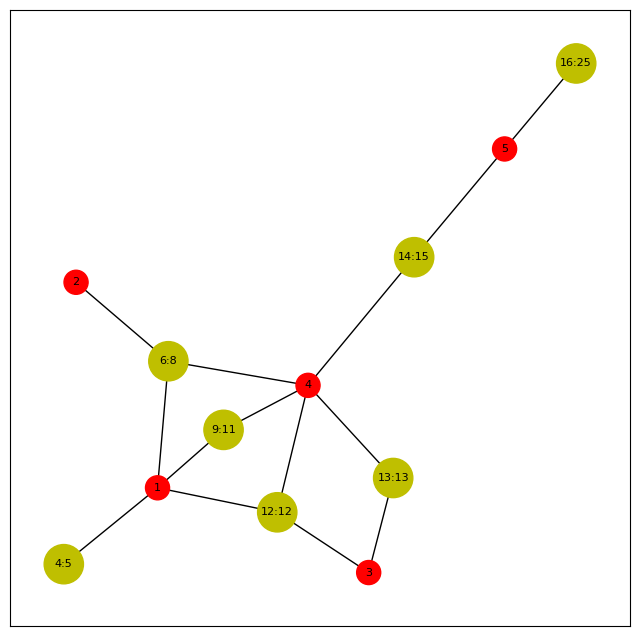

data/nmr_test/testE.nmr


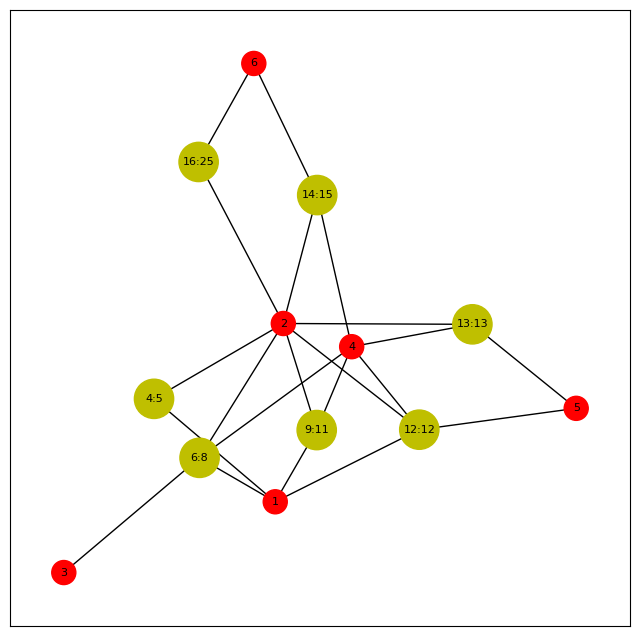

data/nmr_test/testF.nmr


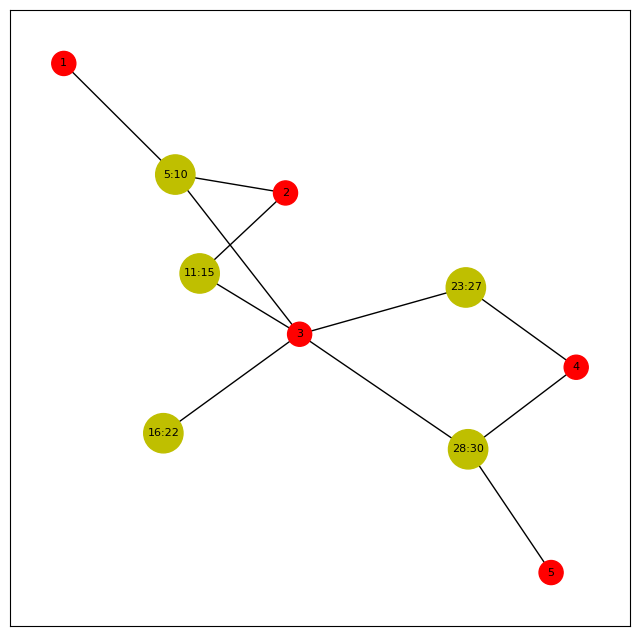

data/nmr_test/testG.nmr


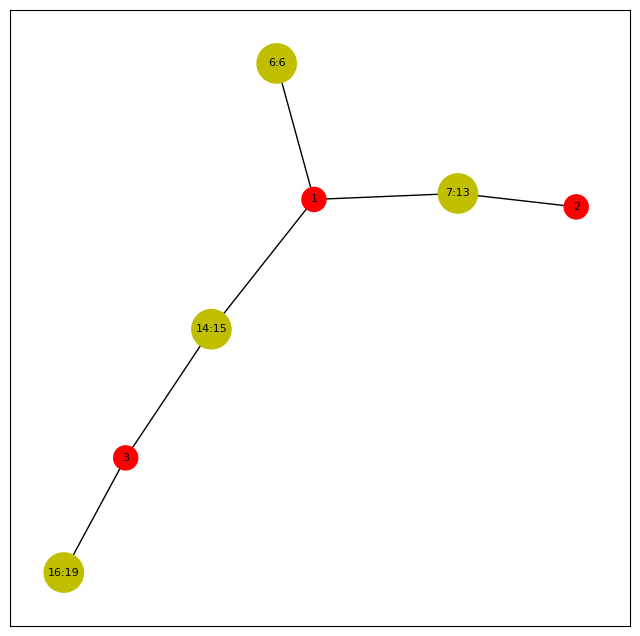

data/nmr_test/testH.nmr


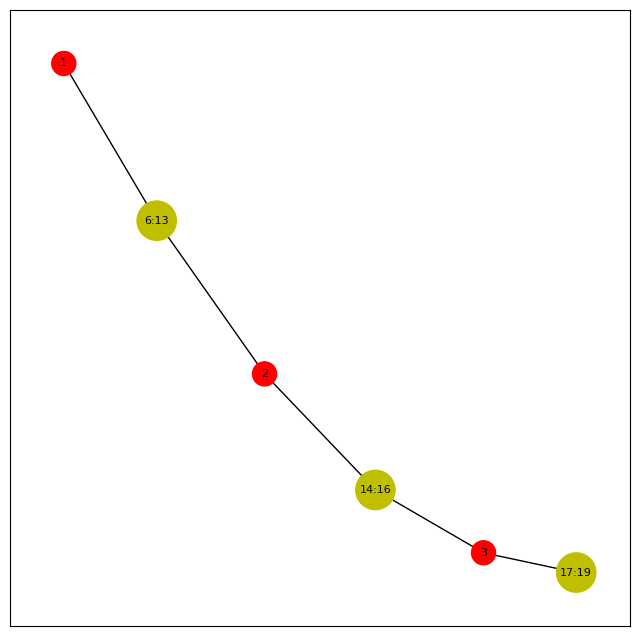

In [33]:
wdir = os.path.join('data','nmr_test')
for fn in sorted(os.listdir(wdir)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(wdir, fn)
    nmr = NMR(fn)
    E, S = nmr.E, nmr.S # edges and segments
    G = nmr.ordering_graph # ordering graph
    plot_graph(G, fn, True)

### Read LOG Files

In [ ]:
WDIR = ['DATA_EPSD_00_DMAX_50', 'DATA_EPSD_00_DMAX_60']
df = []
for wdir in WDIR:
    print('Processing wdir=%s' % wdir)
    dmax = int(wdir.split('_')[-1])
    for flog in tqdm.tqdm(sorted(os.listdir(wdir))):
        if not flog.endswith('.log'):
            continue
        pid = flog.replace('.log','')
        flog = os.path.join(wdir, flog)
        # check if the problem was pickled        
        df_log = {'pid': pid, 'dmax':dmax}
        with open(flog, 'r') as fid:
            for row in fid:
                row = row.replace(':','').replace('\n','').split(' ')
                field = row[1]
                if 'fnmr' in field:
                    value = row[-1]
                elif 'timeoutBB' in field:
                    value = int(row[-1])
                elif 'time' in field:
                    value = float(row[-1])
                else:
                    value = int(row[-1])
                df_log[field] = value
        df.append(df_log)
df = pd.DataFrame(df)
df['gapRL'] = (df['costSB'] - df['costRX']) / df['costRX']
df['gapBB'] = (df['costSB'] - df['costBB']) / df['costBB']
df['gapPT'] = (df['costSB'] - df['costPT']) / df['costPT']
C = {'timeoutBB':'tOutBB','timeoutPT':'tOutPT'}
df.rename(columns=C, inplace=True)
df.drop(['fnmr'],axis=1,inplace=True)
fname = 'results.xlsx'
print('Save', fname)
df.to_excel(fname,index=False)
df.head()

In [ ]:
# time out cases
dfA = df[df['timeoutPT'] + df['timeoutBB'] >= 1]
dfA = dfA[['pid','dmax','costRELAX','costSBBU','costBB','costPT','gapRL','timeBB','timePT']]
dfA

In [ ]:
df.groupby(by=['pid','dmax']).mean()

In [ ]:
df50 = df[df['dmax']==50]
df60 = df[df['dmax']==60]

### Instance Analysis

In [ ]:
fn  = 'DATA_EPSD_00_DMAX_50/1n6t.nmr'
nmr = NMR(fn)
E, S = nmr.E, nmr.S
print('len(E):',len(E),'len(S):',len(S))

In [ ]:
G = nmr.ordering_graph
plot_graph(G, fn, False)

In [ ]:
order, costBF = order_brute(nmr)
print('costBF=',costBF)

In [ ]:
x, y, z = [], [], []
for sid in S:
    s = S[sid]
    x.append(s.i)
    y.append(s.j)
    z.append('nmr')
    x.append(s.i)
    y.append(s.i)
    z.append('x==y')
df = {'x':x, 'y':y, 'z':z}
px.scatter(df, x='x', y='y', color='z')

In [ ]:
for eid in E:
    e = E[eid]
    print(eid, e.i, e.j, e.sid)

In [ ]:
S[1].i, S[1].j

In [ ]:
# degree of each segment
degree = {}
for sid in S:
    s: NMRSegment = S[sid]
    d = len(s.eid)
    if d not in degree:
        degree[d] = 0
    degree[d] += 1
# convert from dict to list
degree = sorted([(d, degree[d]) for d in degree])


In [ ]:
x, y = list(zip(*degree))
df = {'segment degree':x,'#occurrencies':y}
px.scatter(df,x='segment degree',y='#occurrencies')

In [ ]:
# any pair of segments have the same edges? 
K = set()
for sid in tqdm.tqdm(S):
    s: NMRSegment = S[sid]
    K.add(tuple(sorted(eid for eid in s.eid)))
print('#K:',len(K), '#S:', len(S))

In [ ]:
# remover de (edge) 'a' de s.sid se existir (edge) 'b' s.sid tq b \subset a.
import copy
W = copy.deepcopy(S)
df = {'sid':[], 'degOld':[], 'degNew':[]}
for sid in tqdm.tqdm(sorted(W)):
    s : NMRSegment = W[sid]
    s_eid = sorted(s.eid)
    R = set() # eid to be removed
    for eidA in s_eid:
        a: NMREdge = E[eidA]
        for eidB in s_eid:
            if eidA == eidB:
                continue
            b: NMREdge = E[eidB]
            # a contains b, so b precedes a
            if a.i <= b.i and b.j <= a.j:
                R.add(eidA)
                break
    s.eid = s.eid - R
    df['sid'].append(sid)
    df['degOld'].append(len(s_eid))
    df['degNew'].append(len(s.eid))


In [ ]:
px.scatter(df, x='degOld', y='degNew', text='sid')

In [ ]:
sid = 623
s = S[sid]
for eid in s.eid:
    e: NMREdge = E[eid]
    print('(%d, %d)' % (e.i, e.j))


In [ ]:
sid = 623
s = W[sid]
for eid in s.eid:
    e: NMREdge = E[eid]
    print('(%d, %d)' % (e.i, e.j))


In [ ]:
s.i, s.j